In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Just a formatting related plugin
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

In [4]:
import sys

sys.path.append("../")

<IPython.core.display.Javascript object>

In [5]:
import numpy as np
import torch
from pathlib import Path

import sbi
from sbi import utils as utils
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi

from snpe.simulations.simulator_class import DoubleRhoSimulator

<IPython.core.display.Javascript object>

In [20]:
import pandas as pd
import pyreadr

<IPython.core.display.Javascript object>

In [6]:
sbi.__version__

'0.14.2'

<IPython.core.display.Javascript object>

In [7]:
torch.device("cuda")

device(type='cuda')

<IPython.core.display.Javascript object>

In [11]:
torch.get_num_threads()

8

<IPython.core.display.Javascript object>

In [9]:
torch.set_num_threads(8)

<IPython.core.display.Javascript object>

# Simulate time series of review histograms

In [11]:
params = {
    "review_prior": np.ones(5),
    "tendency_to_rate": 0.05,
    "simulation_type": "timeseries",
}
simulator = DoubleRhoSimulator(params)

<IPython.core.display.Javascript object>

In [13]:
simulator.load_simulator(Path("../artifacts/hyperparameter_tuning/cnn_tuning/"))

<IPython.core.display.Javascript object>

In [12]:
# simulator.simulate(num_simulations=20_000)
simulator.simulate(num_simulations=5_000)

Simulations: 100%|██████████| 5000/5000 [20:36<00:00,  4.04it/s] 


<IPython.core.display.Javascript object>

In [13]:
simulator.save_simulations(Path("./"))

<IPython.core.display.Javascript object>

(array([2969., 2931., 2939., 3009., 3007., 3049., 3118., 2960., 3022.,
        2996.]),
 array([  21.,  519., 1017., 1515., 2013., 2511., 3009., 3507., 4005.,
        4503., 5001.]),
 <BarContainer object of 10 artists>)

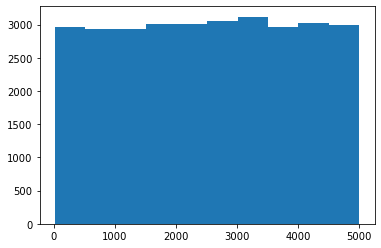

<IPython.core.display.Javascript object>

In [17]:
plt.hist([len(simulation) for simulation in simulator.simulations])

# Testing

In [14]:
from torch.utils import data

<IPython.core.display.Javascript object>

In [297]:
simulations = [
    torch.from_numpy(simulation).type(torch.FloatTensor)
    for simulation in simulator.simulations
]
parameters = torch.from_numpy(simulator.simulation_parameters["rho"]).type(
    torch.FloatTensor
)

<IPython.core.display.Javascript object>

In [298]:
sim_lens = [len(simulation) for simulation in simulations]
max_len = max(sim_lens)

padded_simulations = simulations[0].data.new_empty((len(simulations), max_len, 5))
for i, simulation in enumerate(simulations):
    padded_simulations[i, : sim_lens[i], :] = simulation
    if sim_lens[i] < max_len:
        padded_simulations[i, sim_lens[i] :, :] = torch.from_numpy(np.array(np.nan))
padded_simulations = padded_simulations.permute(0, 2, 1)

<IPython.core.display.Javascript object>

In [299]:
int(torch.nonzero(torch.isnan(padded_simulations[0, 0, :]))[0])

2490

<IPython.core.display.Javascript object>

In [300]:
torch.nonzero(torch.isnan(padded_simulations[0, 0, :2491]))

tensor([[2490]])

<IPython.core.display.Javascript object>

In [329]:
padded_simulations.size()

torch.Size([5000, 5, 3001])

<IPython.core.display.Javascript object>

In [304]:
len(torch.nonzero(torch.isnan(padded_simulations[0, 0, :])))

511

<IPython.core.display.Javascript object>

In [ ]:
x_lens = [len(simulation) for simulation in x]
max_x_len = max(x_lens)

out_x = x[0].data.new_empty((len(x), max_x_len, 5))
for i, simulation in enumerate(x):
    out_x[i, : x_lens[i], :] = simulation
    if x_lens[i] < max_x_len:
        out_x[i, x_lens[i] :, :] = simulation[-1, :].repeat((max_x_len - x_lens[i], 1))

In [13]:
# Batch by length of time-series
# https://discuss.pytorch.org/t/tensorflow-esque-bucket-by-sequence-length/41284
# Not using anymore 

class SbiDataset(torch.utils.data.Dataset):
    "Characterizes a dataset for PyTorch"

    def __init__(self, theta, x, prior_masks):
        "Initialization"
        self.theta = theta
        self.x = x
        self.prior_masks = prior_masks

    def __len__(self):
        "Denotes the total number of samples"
        return len(self.theta)

    def __getitem__(self, index):
        "Generates one sample of data"
        return self.theta[index], self.x[index], self.prior_masks[index]

<IPython.core.display.Javascript object>

In [330]:
def pad_collate(batch):
    (theta, x, prior_masks) = zip(*batch)
    x_lens = []
    for simulation in x:
        nan_values = torch.nonzero(torch.isnan(simulation[0, :]))
        if len(nan_values) > 0:
            x_lens.append(nan_values[0])
        else:
            x_lens.append(len(simulation[0, :]))
    max_x_len = max(x_lens)

    """
    out_x = x[0].data.new_empty((len(x), max_x_len, 5))
    for i, simulation in enumerate(x):
        if x_lens[i] == max_x_len:
            out_x[i, :, :] = simulation[:max_x_len, :]
        else:
            out_x[i, : x_lens[i], :] = simulation[: x_lens[i], :]
            out_x[i, x_lens[i] :, :] = simulation[x_lens[i] - 1, :].repeat(
                (max_x_len - x_lens[i], 1)
            )

    return theta, out_x.permute(0, 2, 1), prior_masks
    """
    out_x = x[0].data.new_empty((len(x), 5, max_x_len))
    for i, simulation in enumerate(x):
        if x_lens[i] == max_x_len:
            out_x[i, :, :] = simulation[:, :max_x_len]
        else:
            out_x[i, :, : x_lens[i]] = simulation[:, : x_lens[i]]
            out_x[i, :, x_lens[i] :] = simulation[:, x_lens[i] - 1].repeat(
                (1, max_x_len - x_lens[i])
            )
    return (
        torch.cat([param[None, :] for param in theta]),
        out_x,
        torch.cat(prior_masks, axis=0)[:, None],
    )

<IPython.core.display.Javascript object>

In [331]:
class GlobalMaxPooling1D(torch.nn.Module):
    def __init__(self, data_format="channels_last"):
        super(GlobalMaxPooling1D, self).__init__()
        self.data_format = data_format
        self.step_axis = 1 if self.data_format == "channels_last" else 2

    def forward(self, input):
        return torch.max(input, axis=self.step_axis).values

<IPython.core.display.Javascript object>

In [332]:
dim = 32
kernel_size = 5

embedding_net = torch.nn.Sequential(
    torch.nn.Conv1d(
        in_channels=5,
        out_channels=dim,
        kernel_size=kernel_size,
        padding=(kernel_size - 1),
        dilation=1,
    ),
    torch.nn.LeakyReLU(),
    torch.nn.Conv1d(
        in_channels=dim,
        out_channels=dim,
        kernel_size=kernel_size,
        padding=(kernel_size - 1) * 2,
        dilation=2,
    ),
    torch.nn.LeakyReLU(),
    torch.nn.Conv1d(
        in_channels=dim,
        out_channels=dim,
        kernel_size=kernel_size,
        padding=(kernel_size - 1) * 4,
        dilation=4,
    ),
    torch.nn.LeakyReLU(),
    torch.nn.Conv1d(
        in_channels=dim,
        out_channels=dim,
        kernel_size=kernel_size,
        padding=(kernel_size - 1) * 8,
        dilation=8,
    ),
    torch.nn.LeakyReLU(),
    GlobalMaxPooling1D(data_format="channels_not_last"),
    torch.nn.LeakyReLU(),
)

<IPython.core.display.Javascript object>

In [333]:
torch.__version__

'1.8.0a0+65d5004'

<IPython.core.display.Javascript object>

In [334]:
# 2 parameters, positive and negative rho
prior = utils.BoxUniform(
    low=torch.tensor([0.0, 0.0]).type(torch.FloatTensor),
    high=torch.tensor([4.0, 4.0]).type(torch.FloatTensor),
)

<IPython.core.display.Javascript object>

In [335]:
neural_posterior = utils.posterior_nn(
    model="maf", embedding_net=embedding_net, z_score_x=False
)

<IPython.core.display.Javascript object>

In [336]:
inference = SNPE(
    prior=prior,
    density_estimator=neural_posterior,
    device="cpu",
    show_progress_bars=True,
)

<IPython.core.display.Javascript object>

In [337]:
inference = inference.append_simulations(parameters, padded_simulations)

<IPython.core.display.Javascript object>

In [338]:
density_estimator = inference.train(
    training_batch_size=50,
    show_train_summary=True,
    exclude_invalid_x=False,
    dataloader_kwargs={"collate_fn": pad_collate},
)

Neural network successfully converged after 20 epochs.

        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 20
        Best validation performance: -inf
        -------------------------
        


<IPython.core.display.Javascript object>

In [313]:
theta, x, prior_masks = inference.get_simulations(0, False)

<IPython.core.display.Javascript object>

In [314]:
validation_fraction = 0.2
num_total_examples = len(theta)
num_training_examples = int((1 - validation_fraction) * num_total_examples)
num_validation_examples = num_total_examples - num_training_examples

permuted_indices = torch.randperm(num_total_examples)
inference.train_indices, inference.val_indices = (
    permuted_indices[:num_training_examples],
    permuted_indices[num_training_examples:],
)

<IPython.core.display.Javascript object>

In [315]:
dataset = data.TensorDataset(theta, x, prior_masks)

<IPython.core.display.Javascript object>

In [316]:
dataloader_kwargs = {"collate_fn": pad_collate}
training_batch_size = 50

train_loader_kwargs = {
    "batch_size": min(training_batch_size, num_training_examples),
    "drop_last": True,
    "sampler": data.sampler.SubsetRandomSampler(inference.train_indices),
}
train_loader_kwargs = (
    dict(train_loader_kwargs, **dataloader_kwargs)
    if dataloader_kwargs is not None
    else train_loader_kwargs
)
val_loader_kwargs = {
    "batch_size": min(training_batch_size, num_validation_examples),
    "shuffle": False,
    "drop_last": True,
    "sampler": data.sampler.SubsetRandomSampler(inference.val_indices),
}
val_loader_kwargs = (
    dict(val_loader_kwargs, **dataloader_kwargs)
    if dataloader_kwargs is not None
    else val_loader_kwargs
)

<IPython.core.display.Javascript object>

In [317]:
train_loader = data.DataLoader(dataset, **train_loader_kwargs)
val_loader = data.DataLoader(dataset, **val_loader_kwargs)

<IPython.core.display.Javascript object>

In [318]:
for batch in train_loader:
    if torch.sum(torch.isnan(batch[1])) > 0:
        print(batch)

<IPython.core.display.Javascript object>

In [291]:
batch = next(iter(val_loader))

<IPython.core.display.Javascript object>

In [342]:
batch[1].shape

torch.Size([50, 5, 2831])

<IPython.core.display.Javascript object>

In [187]:
val_loader_kwargs = {
    "batch_size": min(training_batch_size, num_validation_examples),
    "shuffle": False,
    "drop_last": True,
    "sampler": data.sampler.SubsetRandomSampler(inference.val_indices),
}

<IPython.core.display.Javascript object>

In [341]:
batch[2].shape

torch.Size([50, 1])

<IPython.core.display.Javascript object>

In [339]:
inference._summary["validation_log_probs"]

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

<IPython.core.display.Javascript object>

In [340]:
inference._neural_net._embedding_net

Sequential(
  (0): Conv1d(5, 32, kernel_size=(5,), stride=(1,), padding=(4,))
  (1): LeakyReLU(negative_slope=0.01)
  (2): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(8,), dilation=(2,))
  (3): LeakyReLU(negative_slope=0.01)
  (4): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(16,), dilation=(4,))
  (5): LeakyReLU(negative_slope=0.01)
  (6): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(32,), dilation=(8,))
  (7): LeakyReLU(negative_slope=0.01)
  (8): GlobalMaxPooling1D()
  (9): LeakyReLU(negative_slope=0.01)
)

<IPython.core.display.Javascript object>

In [347]:
calibration_kernel = lambda x: torch.ones([len(x)], device=inference._device)
proposal = inference._proposal_roundwise[-1]

inference._loss(batch[0], batch[1], batch[2], calibration_kernel, proposal)

TypeError: 'NoneType' object is not callable

<IPython.core.display.Javascript object>

In [350]:
inference._neural_net.log_prob(batch[0], batch[1])

tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan], grad_fn=<AddBackward0>)

<IPython.core.display.Javascript object>

In [367]:
type(inference._neural_net._transform)

nflows.transforms.base.CompositeTransform

<IPython.core.display.Javascript object>

In [362]:
embedded_context = inference._neural_net._embedding_net(batch[1])
embedded_context.shape

torch.Size([50, 32])

<IPython.core.display.Javascript object>

In [363]:
noise, logabsdet = inference._neural_net._transform(batch[0], context=embedded_context)

<IPython.core.display.Javascript object>

In [378]:
batch[0].shape

torch.Size([50, 2])

<IPython.core.display.Javascript object>

In [372]:
funcs = inference._neural_net._transform._transforms

<IPython.core.display.Javascript object>

In [383]:
output = funcs[0](batch[0], embedded_context)

<IPython.core.display.Javascript object>

In [394]:
embedded_context[:3, :]

tensor([[ 2.5113e+00,  1.0580e+00,  4.8916e-01,  5.9571e-01,  1.5836e+00,
          6.1876e-01,  2.6522e-01,  8.0801e-02,  2.2957e+00,  1.0312e-01,
          1.5233e+00,  6.1204e-01,  7.9613e-01,  7.0672e-01, -7.3818e-07,
          1.2850e+00,  4.7510e-01,  1.6540e+00,  1.2027e+00,  1.8042e+00,
          1.2620e+00,  1.4153e+00,  2.3188e+00,  1.5748e+00,  1.6403e-01,
          1.2145e+00,  1.2749e+00,  9.0538e-01,  6.7170e-02,  1.1587e+00,
          4.9226e-02,  7.7660e-01],
        [ 3.1293e+00,  9.0136e-01,  1.5473e-01,  9.1228e-01,  1.5474e+00,
          6.2536e-01,  2.6384e-01,  2.6619e-01,  2.1917e+00, -6.9791e-06,
          1.5950e+00,  9.7544e-02,  2.2587e-02,  3.2819e-01, -1.8370e-06,
          1.4423e+00,  1.3951e+00,  1.8478e+00,  1.5963e+00,  2.1966e+00,
          9.2115e-01,  1.3336e+00,  2.9138e+00,  1.4567e+00,  1.3662e-01,
          9.1841e-01,  3.4990e-01,  1.0697e+00,  1.6917e-01,  9.3338e-01,
          3.8452e-02,  9.3570e-01],
        [ 2.2175e+01,  1.0745e+01,  8.39

<IPython.core.display.Javascript object>

In [ ]:
embedded_context = self._embedding_net(context)
noise, logabsdet = self._transform(inputs, context=embedded_context)
log_prob = self._distribution.log_prob(noise, context=embedded_context)
return log_prob + logabsdet


In [25]:
inference._neural_net.to(device="cpu")

Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): AffineTransform()
      (1): CompositeTransform(
        (_transforms): ModuleList(
          (0): CompositeTransform(
            (_transforms): ModuleList(
              (0): MaskedAffineAutoregressiveTransform(
                (autoregressive_net): MADE(
                  (initial_layer): MaskedLinear(in_features=2, out_features=50, bias=True)
                  (context_layer): Linear(in_features=32, out_features=50, bias=True)
                  (blocks): ModuleList(
                    (0): MaskedFeedforwardBlock(
                      (batch_norm): BatchNorm1d(50, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
                      (linear): MaskedLinear(in_features=50, out_features=50, bias=True)
                      (dropout): Dropout(p=0.0, inplace=False)
                    )
                    (1): MaskedFeedforwardBlock(
                      (batch_norm): BatchNorm1d(50, e

<IPython.core.display.Javascript object>

In [26]:
posterior = inference.build_posterior(density_estimator)

<IPython.core.display.Javascript object>

In [32]:
samples1 = posterior.sample(
    (10000,), x=torch.tensor(simulations[100, :, :][None, :, :]).type(torch.FloatTensor)
)
samples2 = posterior.sample(
    (10000,), x=torch.tensor(simulations[200, :, :][None, :, :]).type(torch.FloatTensor)
)
samples3 = posterior.sample(
    (10000,), x=torch.tensor(simulations[300, :, :][None, :, :]).type(torch.FloatTensor)
)

/home/narendra/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


/home/narendra/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


/home/narendra/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


<IPython.core.display.Javascript object>

tensor([3.2699, 1.7343])


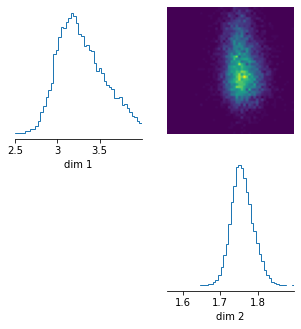

<IPython.core.display.Javascript object>

In [33]:
print(parameters[100, :])
_ = utils.pairplot(samples1, fig_size=(5, 5))

tensor([0.8032, 1.6031])


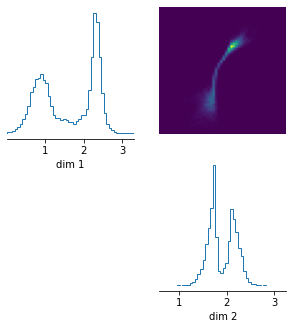

<IPython.core.display.Javascript object>

In [34]:
print(parameters[200, :])
_ = utils.pairplot(samples2, fig_size=(5, 5))

**The time series model is able to capture the bi-modal distribution here, which the histogram model wasn't able to capture at all (see next section). So, heavily U-shaped distributions weren't being diagnosed very well by the histogram based model**

tensor([3.0813, 0.8259])


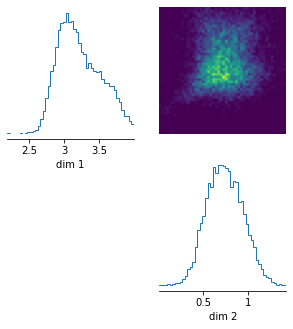

<IPython.core.display.Javascript object>

In [35]:
print(parameters[300, :])
_ = utils.pairplot(samples3, fig_size=(5, 5))

In [126]:
a = torch.rand((10, 4))
b = [torch.rand((np.random.randint(2, 25), 5)) for i in range(10)]
c = torch.rand((10, 8))

<IPython.core.display.Javascript object>

In [134]:
dataset = SbiDataset(
    a,
    b,
    c,
)

<IPython.core.display.Javascript object>

In [135]:
dataset

<IPython.core.display.Javascript object>

In [136]:
num_total_examples = len(a)
permuted_indices = torch.randperm(num_total_examples)
num_training_examples = int((1 - 0.2) * num_total_examples)
num_validation_examples = num_total_examples - num_training_examples
train_indices, val_indices = (
    permuted_indices[:num_training_examples],
    permuted_indices[num_training_examples:],
)

<IPython.core.display.Javascript object>

In [137]:
train_indices.shape, val_indices.shape

(torch.Size([8]), torch.Size([2]))

<IPython.core.display.Javascript object>

In [138]:
train_loader = data.DataLoader(
    dataset,
    batch_size=3,
    drop_last=True,
    sampler=data.SubsetRandomSampler(train_indices),
    collate_fn=pad_collate,
)

<IPython.core.display.Javascript object>

In [118]:
val_loader = data.DataLoader(
    dataset,
    batch_size=1,
    drop_last=True,
    sampler=data.SubsetRandomSampler(val_indices),
)

<IPython.core.display.Javascript object>

In [139]:
for batch in train_loader:
    print(batch)

((tensor([0.0938, 0.2266, 0.5865, 0.0844]), tensor([0.6467, 0.3087, 0.4649, 0.9545]), tensor([0.4500, 0.7960, 0.2956, 0.9495])), tensor([[[0.2255, 0.3298, 0.6563, 0.5343, 0.3766, 0.3344, 0.2329, 0.3316,
          0.2487, 0.2490, 0.3193, 0.2103, 0.1466],
         [0.4529, 0.3691, 0.0236, 0.9328, 0.4257, 0.0886, 0.9011, 0.5593,
          0.6986, 0.4687, 0.4945, 0.0837, 0.2472],
         [0.5774, 0.5915, 0.1212, 0.2699, 0.1313, 0.3425, 0.4248, 0.8032,
          0.9498, 0.2343, 0.0633, 0.3433, 0.3722],
         [0.5073, 0.3947, 0.8633, 0.2476, 0.0686, 0.1055, 0.3620, 0.3604,
          0.8582, 0.0306, 0.8948, 0.7048, 0.7239],
         [0.3927, 0.3932, 0.5278, 0.9778, 0.5840, 0.0418, 0.9231, 0.2934,
          0.1010, 0.8491, 0.4362, 0.9943, 0.3718]],

        [[0.3574, 0.3402, 0.5825, 0.9969, 0.9969, 0.9969, 0.9969, 0.9969,
          0.9969, 0.9969, 0.9969, 0.9969, 0.9969],
         [0.8613, 0.3894, 0.5489, 0.8201, 0.8201, 0.8201, 0.8201, 0.8201,
          0.8201, 0.8201, 0.8201, 0.8201, 0.8

<IPython.core.display.Javascript object>

In [140]:
batch[1].size()

torch.Size([3, 5, 18])

<IPython.core.display.Javascript object>

In [101]:
train_indices

tensor([2, 5, 7, 6, 0, 9, 1, 8])

<IPython.core.display.Javascript object>

In [141]:
test = embedding_net(batch[1])

<IPython.core.display.Javascript object>

In [143]:
test.size()

torch.Size([3, 32])

<IPython.core.display.Javascript object>

In [40]:
batch[0].data[-1, :].repeat((5, 1))

tensor([[0.1474, 0.5095, 0.7636, 0.5653],
        [0.1474, 0.5095, 0.7636, 0.5653],
        [0.1474, 0.5095, 0.7636, 0.5653],
        [0.1474, 0.5095, 0.7636, 0.5653],
        [0.1474, 0.5095, 0.7636, 0.5653]])

<IPython.core.display.Javascript object>

In [39]:
batch[0]

tensor([[0.9683, 0.9324, 0.2058, 0.3007],
        [0.2246, 0.4083, 0.1650, 0.4630],
        [0.1474, 0.5095, 0.7636, 0.5653]])

<IPython.core.display.Javascript object>

In [18]:
simulator.simulations[0].shape

(1060, 5)

<IPython.core.display.Javascript object>

In [76]:
# 2 parameters, positive and negative rho
prior = utils.BoxUniform(
    low=torch.tensor([0.0, 0.0]).type(torch.FloatTensor),
    high=torch.tensor([4.0, 4.0]).type(torch.FloatTensor),
)

<IPython.core.display.Javascript object>

In [77]:
neural_posterior = utils.posterior_nn(
    model="made",
    embedding_net=embedding_net,
)

<IPython.core.display.Javascript object>

In [78]:
inference = SNPE(
    prior=prior,
    density_estimator=neural_posterior,
    device="cpu",
    show_progress_bars=True,
)

<IPython.core.display.Javascript object>

In [13]:
simulator.simulations

array([array([[  0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   1.],
       [  1.,   0.,   0.,   0.,   1.],
       ...,
       [370., 255., 162.,  91., 179.],
       [371., 255., 162.,  91., 179.],
       [371., 256., 162.,  91., 179.]]),
       array([[  0.,   0.,   0.,   0.,   0.],
       [  1.,   0.,   0.,   0.,   0.],
       [  2.,   0.,   0.,   0.,   0.],
       ...,
       [111., 124.,  88.,  78.,  60.],
       [111., 124.,  88.,  79.,  60.],
       [111., 124.,  88.,  80.,  60.]]),
       array([[  0.,   0.,   0.,   0.,   0.],
       [  1.,   0.,   0.,   0.,   0.],
       [  1.,   1.,   0.,   0.,   0.],
       ...,
       [ 16., 339., 224.,  42.,   4.],
       [ 16., 340., 224.,  42.,   4.],
       [ 16., 340., 225.,  42.,   4.]]),
       ...,
       array([[  0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   1.,   0.,   0.],
       [  0.,   1.,   1.,   0.,   0.],
       ...,
       [ 58., 443., 159.,  67.,  35.],
       [ 58., 444., 159.,  67.,  35.],
       [ 

<IPython.core.display.Javascript object>

In [13]:
simulations = [
    torch.from_numpy(simulation).type(torch.FloatTensor)
    for simulation in simulator.simulations
]
parameters = torch.from_numpy(simulator.simulation_parameters["rho"]).type(
    torch.FloatTensor
)

<IPython.core.display.Javascript object>

In [43]:
density_estimator = inference.append_simulations(parameters, simulations).train(
    training_batch_size=50, show_train_summary=True
)

TypeError: expected Tensor as element 0 in argument 0, but got list

<IPython.core.display.Javascript object>

In [49]:
a = pad_collate(
    [
        [i for i in range(len(simulations))],
        simulations,
        [i for i in range(len(simulations))],
    ]
)

ValueError: too many values to unpack (expected 3)

<IPython.core.display.Javascript object>

In [50]:
b = [
    [i for i in range(len(simulations))],
    simulations,
    [i for i in range(len(simulations))],
]

<IPython.core.display.Javascript object>

In [51]:
len(b)

3

<IPython.core.display.Javascript object>

In [14]:
x = simulations

<IPython.core.display.Javascript object>

In [15]:
x_lens = [len(simulation) for simulation in x]
max_x_len = max(x_lens)

out_x = x[0].data.new_empty((len(x), max_x_len, 5))
for i, simulation in enumerate(x):
    out_x[i, : x_lens[i], :] = simulation
    if x_lens[i] < max_x_len:
        out_x[i, x_lens[i] :, :] = simulation[-1, :].repeat((max_x_len - x_lens[i], 1))

<IPython.core.display.Javascript object>

In [16]:
out_x.shape

torch.Size([20000, 3001, 5])

<IPython.core.display.Javascript object>

In [17]:
dim = 8
kernel_size = 5

embedding_net = torch.nn.Sequential(
    torch.nn.Conv1d(
        in_channels=5,
        out_channels=dim,
        kernel_size=kernel_size,
        padding=(kernel_size - 1),
        dilation=1,
    ),
    torch.nn.LeakyReLU(),
    torch.nn.Conv1d(
        in_channels=dim,
        out_channels=dim,
        kernel_size=kernel_size,
        padding=(kernel_size - 1) * 2,
        dilation=2,
    ),
    torch.nn.LeakyReLU(),
    torch.nn.Conv1d(
        in_channels=dim,
        out_channels=dim,
        kernel_size=kernel_size,
        padding=(kernel_size - 1) * 4,
        dilation=4,
    ),
    torch.nn.LeakyReLU(),
    torch.nn.Conv1d(
        in_channels=dim,
        out_channels=dim,
        kernel_size=kernel_size,
        padding=(kernel_size - 1) * 8,
        dilation=8,
    ),
    torch.nn.LeakyReLU(),
    torch.nn.MaxPool1d(kernel_size=5),
    torch.nn.Flatten(start_dim=1),
    torch.nn.Linear(4896, 128),
    torch.nn.Linear(128, 32),
)

<IPython.core.display.Javascript object>

In [18]:
simulations = out_x.permute(0, 2, 1)
simulations.size()

torch.Size([20000, 5, 3001])

<IPython.core.display.Javascript object>

In [19]:
a = embedding_net(simulations[:10, :, :])

<IPython.core.display.Javascript object>

In [20]:
a.size()

torch.Size([10, 32])

<IPython.core.display.Javascript object>

In [21]:
# 2 parameters, positive and negative rho
prior = utils.BoxUniform(
    low=torch.tensor([0.0, 0.0]).type(torch.FloatTensor),
    high=torch.tensor([4.0, 4.0]).type(torch.FloatTensor),
)

<IPython.core.display.Javascript object>

In [22]:
neural_posterior = utils.posterior_nn(
    model="maf",
    embedding_net=embedding_net,
)

<IPython.core.display.Javascript object>

In [23]:
inference = SNPE(
    prior=prior,
    density_estimator=neural_posterior,
    device="gpu",
    show_progress_bars=True,
)

/etc/anaconda3/envs/sbi/lib/python3.7/site-packages/sbi/utils/torchutils.py:31: UserWarning: GPU was selected as a device for training the neural network. Note
                   that we expect **no** significant speed ups in training for the
                   default architectures we provide. Using the GPU will be effective
                   only for large neural networks with operations that are fast on the
                   GPU, e.g., for a CNN or RNN `embedding_net`.
  GPU, e.g., for a CNN or RNN `embedding_net`."""


<IPython.core.display.Javascript object>

In [24]:
density_estimator = inference.append_simulations(parameters, simulations).train(
    training_batch_size=50, show_train_summary=True
)

Neural network successfully converged after 118 epochs.

        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 118
        Best validation performance: 0.3919
        -------------------------
        


<IPython.core.display.Javascript object>

In [25]:
inference._neural_net.to(device="cpu")

Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): AffineTransform()
      (1): CompositeTransform(
        (_transforms): ModuleList(
          (0): CompositeTransform(
            (_transforms): ModuleList(
              (0): MaskedAffineAutoregressiveTransform(
                (autoregressive_net): MADE(
                  (initial_layer): MaskedLinear(in_features=2, out_features=50, bias=True)
                  (context_layer): Linear(in_features=32, out_features=50, bias=True)
                  (blocks): ModuleList(
                    (0): MaskedFeedforwardBlock(
                      (batch_norm): BatchNorm1d(50, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
                      (linear): MaskedLinear(in_features=50, out_features=50, bias=True)
                      (dropout): Dropout(p=0.0, inplace=False)
                    )
                    (1): MaskedFeedforwardBlock(
                      (batch_norm): BatchNorm1d(50, e

<IPython.core.display.Javascript object>

In [26]:
posterior = inference.build_posterior(density_estimator)

<IPython.core.display.Javascript object>

In [32]:
samples1 = posterior.sample(
    (10000,), x=torch.tensor(simulations[100, :, :][None, :, :]).type(torch.FloatTensor)
)
samples2 = posterior.sample(
    (10000,), x=torch.tensor(simulations[200, :, :][None, :, :]).type(torch.FloatTensor)
)
samples3 = posterior.sample(
    (10000,), x=torch.tensor(simulations[300, :, :][None, :, :]).type(torch.FloatTensor)
)

/home/narendra/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


/home/narendra/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


/home/narendra/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


<IPython.core.display.Javascript object>

tensor([3.2699, 1.7343])


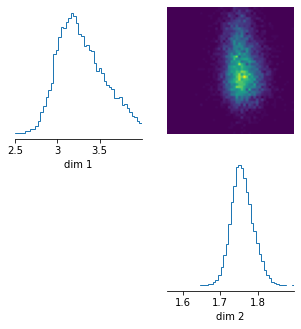

<IPython.core.display.Javascript object>

In [33]:
print(parameters[100, :])
_ = utils.pairplot(samples1, fig_size=(5, 5))

tensor([0.8032, 1.6031])


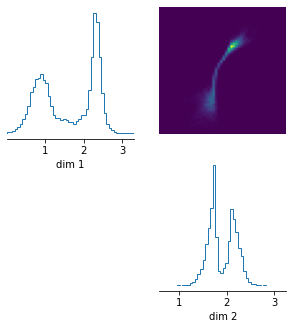

<IPython.core.display.Javascript object>

In [34]:
print(parameters[200, :])
_ = utils.pairplot(samples2, fig_size=(5, 5))

**The time series model is able to capture the bi-modal distribution here, which the histogram model wasn't able to capture at all (see next section). So, heavily U-shaped distributions weren't being diagnosed very well by the histogram based model**

tensor([3.0813, 0.8259])


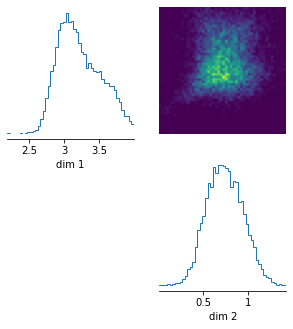

<IPython.core.display.Javascript object>

In [35]:
print(parameters[300, :])
_ = utils.pairplot(samples3, fig_size=(5, 5))

In [39]:
simulations[200][:, -1]

tensor([8.4200e+02, 1.9000e+02, 1.0000e+00, 0.0000e+00, 1.0270e+03])

<IPython.core.display.Javascript object>

In [40]:
a = simulations[200][:, -1].numpy()

<IPython.core.display.Javascript object>

In [43]:
for i in range(5):
    print(a[i])

842.0
190.0
1.0
0.0
1027.0


<IPython.core.display.Javascript object>

# Also do the same with old histogram method

In [45]:
theta = []
output = []
for i in range(len(simulator.simulations)):
    theta.append(simulator.simulation_parameters["rho"][i, :])
    output.append(simulator.simulations[i][-1, :])

<IPython.core.display.Javascript object>

In [46]:
theta = np.array(theta)
output = np.array(output)
theta.shape, output.shape

((20000, 2), (20000, 5))

<IPython.core.display.Javascript object>

In [47]:
# Convert everything into torch tensors to be fed into SNPE
output = torch.from_numpy(output).type(torch.FloatTensor)
# theta = torch.from_numpy(theta).type(torch.FloatTensor)
theta = torch.from_numpy(theta).type(torch.FloatTensor)

<IPython.core.display.Javascript object>

In [50]:
# 2 parameters, positive and negative rho
prior = utils.BoxUniform(
    low=torch.tensor([0.0, 0.0]).type(torch.FloatTensor),
    high=torch.tensor([4.0, 4.0]).type(torch.FloatTensor),
)

<IPython.core.display.Javascript object>

In [51]:
inference = SNPE(prior, device="cpu", show_progress_bars=True)

<IPython.core.display.Javascript object>

In [52]:
density_estimator = inference.append_simulations(theta, output).train(
    training_batch_size=50, show_train_summary=True
)

Neural network successfully converged after 191 epochs.

        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 191
        Best validation performance: -0.0894
        -------------------------
        


<IPython.core.display.Javascript object>

In [53]:
posterior = inference.build_posterior(density_estimator)

<IPython.core.display.Javascript object>

In [56]:
samples1 = posterior.sample(
    (10000,), x=torch.tensor(output[100, :]).type(torch.FloatTensor)
)
samples2 = posterior.sample(
    (10000,), x=torch.tensor(output[200, :]).type(torch.FloatTensor)
)
samples3 = posterior.sample(
    (10000,), x=torch.tensor(output[300, :]).type(torch.FloatTensor)
)

/home/narendra/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


/home/narendra/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


/home/narendra/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


<IPython.core.display.Javascript object>

tensor([3.2699, 1.7343])


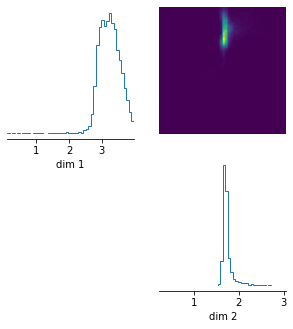

<IPython.core.display.Javascript object>

In [57]:
print(theta[100, :])
_ = utils.pairplot(samples1, fig_size=(5, 5))

tensor([0.8032, 1.6031])


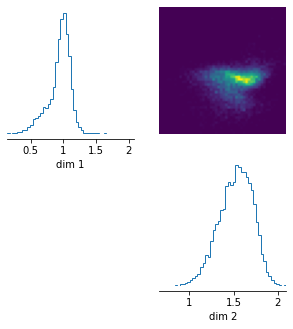

<IPython.core.display.Javascript object>

In [58]:
print(theta[200, :])
_ = utils.pairplot(samples2, fig_size=(5, 5))

tensor([3.0813, 0.8259])


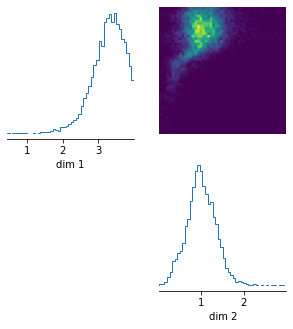

<IPython.core.display.Javascript object>

In [59]:
print(theta[300, :])
_ = utils.pairplot(samples3, fig_size=(5, 5))

# Compare time-series and histogram validation performance on series longer than 1000

# First histogram inference

In [12]:
simulator.simulations

array([array([[  0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   1.],
       [  1.,   0.,   0.,   0.,   1.],
       ...,
       [370., 255., 162.,  91., 179.],
       [371., 255., 162.,  91., 179.],
       [371., 256., 162.,  91., 179.]]),
       array([[  0.,   0.,   0.,   0.,   0.],
       [  1.,   0.,   0.,   0.,   0.],
       [  2.,   0.,   0.,   0.,   0.],
       ...,
       [111., 124.,  88.,  78.,  60.],
       [111., 124.,  88.,  79.,  60.],
       [111., 124.,  88.,  80.,  60.]]),
       array([[  0.,   0.,   0.,   0.,   0.],
       [  1.,   0.,   0.,   0.,   0.],
       [  1.,   1.,   0.,   0.,   0.],
       ...,
       [ 16., 339., 224.,  42.,   4.],
       [ 16., 340., 224.,  42.,   4.],
       [ 16., 340., 225.,  42.,   4.]]),
       ...,
       array([[  0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   1.,   0.,   0.],
       [  0.,   1.,   1.,   0.,   0.],
       ...,
       [ 58., 443., 159.,  67.,  35.],
       [ 58., 444., 159.,  67.,  35.],
       [ 

<IPython.core.display.Javascript object>

In [17]:
simulator.simulation_parameters["rho"].shape

(20000, 2)

<IPython.core.display.Javascript object>

In [24]:
theta = []
output = []
for i in range(len(simulator.simulations)):
    if len(simulator.simulations[i]) > 1000:
        theta.append(simulator.simulation_parameters["rho"][i, :])
        output.append(simulator.simulations[i][1000, :])

<IPython.core.display.Javascript object>

In [25]:
theta = np.array(theta)
output = np.array(output)
theta.shape, output.shape

((13391, 2), (13391, 5))

<IPython.core.display.Javascript object>

In [26]:
# Convert everything into torch tensors to be fed into SNPE
output = torch.from_numpy(output).type(torch.FloatTensor)
# theta = torch.from_numpy(theta).type(torch.FloatTensor)
theta = torch.from_numpy(theta).type(torch.FloatTensor)

<IPython.core.display.Javascript object>

In [28]:
# 2 parameters, positive and negative rho
prior = utils.BoxUniform(
    low=torch.tensor([0.0, 0.0]).type(torch.FloatTensor),
    high=torch.tensor([4.0, 4.0]).type(torch.FloatTensor),
)

<IPython.core.display.Javascript object>

In [29]:
inference = SNPE(prior, device="cpu", show_progress_bars=True)

<IPython.core.display.Javascript object>

In [31]:
density_estimator = inference.append_simulations(theta, output).train(
    training_batch_size=50, show_train_summary=True
)

Neural network successfully converged after 166 epochs.

        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 166
        Best validation performance: 0.0321
        -------------------------
        


<IPython.core.display.Javascript object>

In [34]:
posterior = inference.build_posterior(density_estimator)

<IPython.core.display.Javascript object>

In [35]:
samples1 = posterior.sample(
    (10000,), x=torch.tensor(output[100, :]).type(torch.FloatTensor)
)
samples2 = posterior.sample(
    (10000,), x=torch.tensor(output[200, :]).type(torch.FloatTensor)
)
samples3 = posterior.sample(
    (10000,), x=torch.tensor(output[300, :]).type(torch.FloatTensor)
)

/home/narendra/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


/home/narendra/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


/home/narendra/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>

tensor([1.5518, 1.7110])


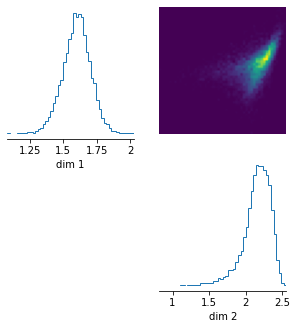

<IPython.core.display.Javascript object>

In [37]:
print(theta[100, :])
_ = utils.pairplot(samples1, fig_size=(5, 5))

tensor([0.2831, 0.6709])


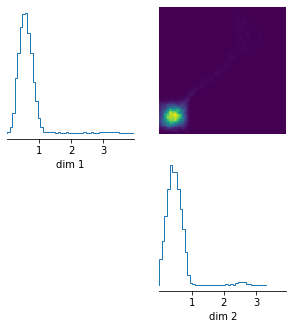

<IPython.core.display.Javascript object>

In [38]:
print(theta[200, :])
_ = utils.pairplot(samples2, fig_size=(5, 5))

tensor([0.1540, 1.7882])


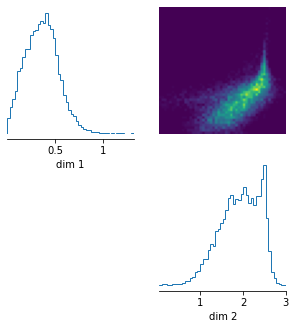

<IPython.core.display.Javascript object>

In [39]:
print(theta[300, :])
_ = utils.pairplot(samples3, fig_size=(5, 5))

# Now time-series inference

In [42]:
theta = []
output = []
for i in range(len(simulator.simulations)):
    if len(simulator.simulations[i]) > 1000:
        theta.append(simulator.simulation_parameters["rho"][i, :])
        output.append(simulator.simulations[i][:1000, :])

<IPython.core.display.Javascript object>

In [43]:
theta = np.array(theta)
output = np.array(output)
output = np.swapaxes(output, 1, 2)
theta.shape, output.shape

((13391, 2), (13391, 5, 1000))

<IPython.core.display.Javascript object>

In [54]:
# Convert everything into torch tensors to be fed into SNPE
output = torch.from_numpy(output).type(torch.FloatTensor)
# theta = torch.from_numpy(theta).type(torch.FloatTensor)
theta = torch.from_numpy(theta).type(torch.FloatTensor)

<IPython.core.display.Javascript object>

In [55]:
dim = 8
kernel_size = 5

embedding_net = torch.nn.Sequential(
    torch.nn.Conv1d(
        in_channels=5,
        out_channels=dim,
        kernel_size=kernel_size,
        padding=(kernel_size - 1),
        dilation=1,
    ),
    torch.nn.LeakyReLU(),
    torch.nn.Conv1d(
        in_channels=dim,
        out_channels=dim,
        kernel_size=kernel_size,
        padding=(kernel_size - 1) * 2,
        dilation=2,
    ),
    torch.nn.LeakyReLU(),
    torch.nn.Conv1d(
        in_channels=dim,
        out_channels=dim,
        kernel_size=kernel_size,
        padding=(kernel_size - 1) * 4,
        dilation=4,
    ),
    torch.nn.LeakyReLU(),
    torch.nn.Conv1d(
        in_channels=dim,
        out_channels=dim,
        kernel_size=kernel_size,
        padding=(kernel_size - 1) * 8,
        dilation=8,
    ),
    torch.nn.LeakyReLU(),
    torch.nn.MaxPool1d(kernel_size=5),
    torch.nn.Flatten(start_dim=1),
    torch.nn.Linear(1696, 128),
    torch.nn.Linear(128, 32),
)

<IPython.core.display.Javascript object>

In [62]:
# 2 parameters, positive and negative rho
prior = utils.BoxUniform(
    low=torch.tensor([0.0, 0.0]).type(torch.FloatTensor),
    high=torch.tensor([4.0, 4.0]).type(torch.FloatTensor),
)

<IPython.core.display.Javascript object>

In [63]:
neural_posterior = utils.posterior_nn(
    model="maf",
    embedding_net=embedding_net,
)

<IPython.core.display.Javascript object>

In [64]:
inference = SNPE(
    prior=prior,
    density_estimator=neural_posterior,
    device="gpu",
    show_progress_bars=True,
)

<IPython.core.display.Javascript object>

In [65]:
density_estimator = inference.append_simulations(theta, output).train(
    training_batch_size=50, show_train_summary=True
)

Neural network successfully converged after 142 epochs.

        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 142
        Best validation performance: 0.4678
        -------------------------
        


<IPython.core.display.Javascript object>

In [67]:
inference._neural_net.to(device="cpu")

Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): AffineTransform()
      (1): CompositeTransform(
        (_transforms): ModuleList(
          (0): CompositeTransform(
            (_transforms): ModuleList(
              (0): MaskedAffineAutoregressiveTransform(
                (autoregressive_net): MADE(
                  (initial_layer): MaskedLinear(in_features=2, out_features=50, bias=True)
                  (context_layer): Linear(in_features=32, out_features=50, bias=True)
                  (blocks): ModuleList(
                    (0): MaskedFeedforwardBlock(
                      (batch_norm): BatchNorm1d(50, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
                      (linear): MaskedLinear(in_features=50, out_features=50, bias=True)
                      (dropout): Dropout(p=0.0, inplace=False)
                    )
                    (1): MaskedFeedforwardBlock(
                      (batch_norm): BatchNorm1d(50, e

<IPython.core.display.Javascript object>

In [68]:
posterior = inference.build_posterior(density_estimator)

<IPython.core.display.Javascript object>

In [69]:
samples1 = posterior.sample(
    (10000,), x=torch.tensor(output[100, :, :][None, :, :]).type(torch.FloatTensor)
)
samples2 = posterior.sample(
    (10000,), x=torch.tensor(output[200, :, :][None, :, :]).type(torch.FloatTensor)
)
samples3 = posterior.sample(
    (10000,), x=torch.tensor(output[300, :, :][None, :, :]).type(torch.FloatTensor)
)

/home/narendra/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


/home/narendra/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


/home/narendra/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


<IPython.core.display.Javascript object>

tensor([1.5518, 1.7110])


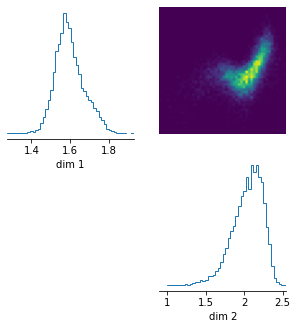

<IPython.core.display.Javascript object>

In [70]:
print(theta[100, :])
_ = utils.pairplot(samples1, fig_size=(5, 5))

tensor([0.2831, 0.6709])


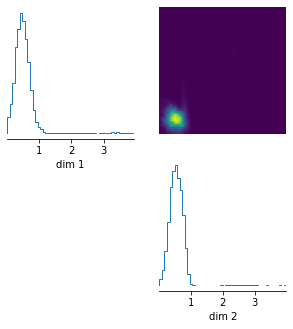

<IPython.core.display.Javascript object>

In [71]:
print(theta[200, :])
_ = utils.pairplot(samples2, fig_size=(5, 5))

tensor([0.1540, 1.7882])


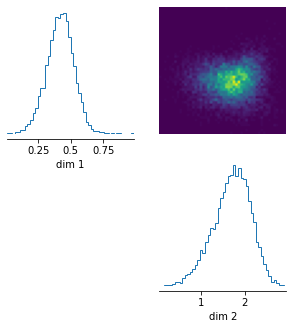

<IPython.core.display.Javascript object>

In [72]:
print(theta[300, :])
_ = utils.pairplot(samples3, fig_size=(5, 5))

# Time series inference on observed data

In [21]:
speakers_timeseries = pyreadr.read_r("../artifacts/hyperparameter_tuning/cnn_tuning/rating_speakers_SNPE.Rds")
speakers_timeseries = speakers_timeseries[None]
speakers_timeseries.head()

,asin,reviewerID,overall,verified,reviewTime,style,reviewerName,unixReviewTime,roll_date.x,val,...,category,description.x,brand,feature,main_cat,tech1,tech2,productGroup,description.y,title
0,B00000K2YR,A2K1QRBOBJ3YM6,5.0,False,"12 14, 2000",{'Package Type:': ' Standard Packaging'},E. JOHNSON,976752000,2000-12-14,76.29,...,"['Electronics', 'Portable Audio & Video', 'CB ...","['Midland Micro 40CH Hand held CB', '', 'Havin...",Midland,"['Portable CB radio with 40 CB channels, 10 NO...",Home Audio & Theater,,,Speakers,"<div class=""aplus""> <p>Having a CB radio while...",Midland 75-822 40 Channel CB-Way Radio
1,B00000K2YR,AXTPPOVT8JWWY,5.0,False,"05 27, 2001",{'Package Type:': ' Standard Packaging'},Tim Hauser,990921600,2001-05-27,76.29,...,"['Electronics', 'Portable Audio & Video', 'CB ...","['Midland Micro 40CH Hand held CB', '', 'Havin...",Midland,"['Portable CB radio with 40 CB channels, 10 NO...",Home Audio & Theater,,,Speakers,"<div class=""aplus""> <p>Having a CB radio while...",Midland 75-822 40 Channel CB-Way Radio
2,B00000K2YR,A1ARE4DLUTEXGY,3.0,False,"11 12, 2001",{'Package Type:': ' Standard Packaging'},KIER L CHRISTENSEN,1005523200,2001-11-12,76.29,...,"['Electronics', 'Portable Audio & Video', 'CB ...","['Midland Micro 40CH Hand held CB', '', 'Havin...",Midland,"['Portable CB radio with 40 CB channels, 10 NO...",Home Audio & Theater,,,Speakers,"<div class=""aplus""> <p>Having a CB radio while...",Midland 75-822 40 Channel CB-Way Radio
3,B00000K2YR,A2CJ99C2FIA17N,5.0,False,"07 11, 2004",{'Package Type:': ' Standard Packaging'},Ethan,1089504000,2004-07-11,76.29,...,"['Electronics', 'Portable Audio & Video', 'CB ...","['Midland Micro 40CH Hand held CB', '', 'Havin...",Midland,"['Portable CB radio with 40 CB channels, 10 NO...",Home Audio & Theater,,,Speakers,"<div class=""aplus""> <p>Having a CB radio while...",Midland 75-822 40 Channel CB-Way Radio
4,B00000K2YR,A120TM984C8SYV,1.0,True,"04 3, 2005",{'Package Type:': ' Standard Packaging'},S. Ellington,1112486400,2005-04-03,76.29,...,"['Electronics', 'Portable Audio & Video', 'CB ...","['Midland Micro 40CH Hand held CB', '', 'Havin...",Midland,"['Portable CB radio with 40 CB channels, 10 NO...",Home Audio & Theater,,,Speakers,"<div class=""aplus""> <p>Having a CB radio while...",Midland 75-822 40 Channel CB-Way Radio


<IPython.core.display.Javascript object>

In [23]:
# Load up the price info
speakers_price = pd.read_csv("../artifacts/hyperparameter_tuning/cnn_tuning/speakers_prod_price_brand_snpe.txt", sep="\t")
speakers_price.head()

,asin,val,productGroup,brand
0,B00000K2YR,77.860,Speakers,Midland
1,B00001P4XA,17.530,Speakers,Koss
2,B00001P4XH,9.010,Speakers,Koss
3,B00001P4ZH,39.355,Speakers,Koss
4,B00001P505,22.955,Speakers,Koss


<IPython.core.display.Javascript object>

In [25]:
assert speakers_price.shape[0] == speakers_timeseries.asin.unique().shape[0]

<IPython.core.display.Javascript object>

In [26]:
pd.testing.assert_frame_equal(speakers_timeseries, speakers_timeseries.sort_values(["asin", "unixReviewTime"]))

<IPython.core.display.Javascript object>

In [27]:
pd.testing.assert_frame_equal(speakers_price, speakers_price.sort_values("asin"))

<IPython.core.display.Javascript object>

In [37]:
# Now run through the product in the timeseries DF and convert their ratings into arrays that can be fed
# into SNPE inference engine
from collections import deque

timeseries_data = []
for product in speakers_price.asin:
    # We only simulate upto 5001 reviews, so we cut off all observed timeseries at that number as well
    timeseries = deque([np.zeros(5)], maxlen=5001)
    ratings = np.array(
        speakers_timeseries.loc[speakers_timeseries.asin == product, "overall"]
    )
    ratings = ratings[:5000]
    for rating in ratings:
        current_histogram = timeseries[-1].copy()
        current_histogram[int(rating - 1)] += 1
        timeseries.append(current_histogram)
    timeseries_data.append(np.array(timeseries))
timeseries_data = np.array(timeseries_data, dtype="object")

<IPython.core.display.Javascript object>

(array([753., 102.,  36.,  20.,  12.,  10.,   6.,   6.,   3.,  11.]),
 array([3.0000e+00, 5.0280e+02, 1.0026e+03, 1.5024e+03, 2.0022e+03,
        2.5020e+03, 3.0018e+03, 3.5016e+03, 4.0014e+03, 4.5012e+03,
        5.0010e+03]),
 <a list of 10 Patch objects>)

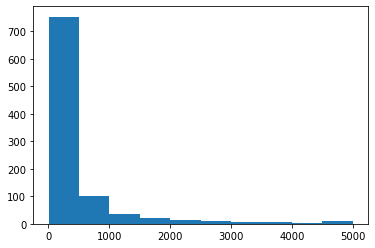

<IPython.core.display.Javascript object>

In [41]:
lens = [len(series) for series in timeseries_data]
plt.hist(lens)